In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
np.random.seed(98765)
from tqdm import tqdm

In [3]:
# ELEC2 data set
# downloaded from https://www.kaggle.com/yashsharan/the-elec2-dataset
data = pd.read_csv('electricity-normalized.csv')
col_names = data.columns
data = data.to_numpy()

# remove the first stretch of time where 'transfer' does not vary
data = data[17760:]

# set up variables for the task (predicting 'transfer')
covariate_col = ['nswprice', 'nswdemand', 'vicprice', 'vicdemand']
response_col = 'transfer'
# keep data points for 9:00am - 12:00pm
keep_rows = np.where((data[:,2]>data[17,2])&(data[:,2]<data[24,2]))[0]

X = data[keep_rows][:,np.where([t in covariate_col for t in col_names])[0]]
Y = data[keep_rows][:,np.where(col_names==response_col)[0]].flatten()
X = X.astype('float64')
Y = Y.astype('float64')

N = X.shape[0]; p = X.shape[1]; alpha = 0.1
train_lag = 100 # start predicting after train_lag many observations

# randomly permuted data 
perm = np.random.choice(N,N,replace=False)
X_perm = X[perm]
Y_perm = Y[perm]

# weights and tags (parameters for new methods)
rho = 0.99; rho_LS = 0.99

In [4]:
data.shape, X.shape, Y.shape

((27552, 9), (3444, 4), (3444,))

In [7]:
# conformal prediction with least squares
def CP_LS(X,Y,x,alpha,weights=[],tags=[]):
    # weights are used for computing quantiles for the prediction interval
    # tags are used as weights in weighted least squares regression
    n = len(Y)
    
    if(len(tags)==0):
        tags = np.ones(n+1)
    
    if(len(weights)==0):
        weights = np.ones(n+1)
    if(len(weights)==n):
        weights = np.r_[weights,1]
    weights = weights / np.sum(weights)
    
    # randomly permute one weight for the regression
    random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])
    tags[np.c_[random_ind,n]] = tags[np.c_[n,random_ind]]

    XtX = (X.T*tags[:-1]).dot(X) + np.outer(x,x)*tags[-1]
    a = Y - X.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))
    b = -X.dot(np.linalg.solve(XtX,x))*tags[-1]
    a1 = -x.T.dot(np.linalg.solve(XtX,(X.T*tags[:-1]).dot(Y)))
    b1 = 1 - x.T.dot(np.linalg.solve(XtX,x))*tags[-1]
    # if we run weighted least squares on (X[1,],Y[1]),...(X[n,],Y[n]),(x,y)
    # then a + b*y = residuals of data points 1,..,n
    # and a1 + b1*y = residual of data point n+1
    
    y_knots = np.sort(np.unique(np.r_[((a-a1)/(b1-b))[b1-b!=0],((-a-a1)/(b1+b))[b1+b!=0]]))
    y_inds_keep = np.where( ((np.abs(np.outer(a1+b1*y_knots,np.ones(n))) > \
       np.abs(np.outer(np.ones(len(y_knots)),a)+np.outer(y_knots,b))) *\
                             weights[:-1] ).sum(1) <= 1-alpha )[0] 
    y_PI = np.array([y_knots[y_inds_keep.min()],y_knots[y_inds_keep.max()]])
    if(weights[:-1].sum() <= 1-alpha):
        y_PI = np.array([-np.inf,np.inf])
    return y_PI


In [12]:
# run all methods
PI_CP_LS = np.zeros((N,2))
PI_CP_LS[:train_lag,0]=-np.inf;PI_CP_LS[:train_lag,1]=np.inf
PI_CP_LS_perm = np.copy(PI_CP_LS)
PI_nexCP_LS = np.copy(PI_CP_LS)
PI_nexCP_LS_perm = np.copy(PI_CP_LS)
PI_nexCP_WLS = np.copy(PI_CP_LS)
PI_nexCP_WLS_perm = np.copy(PI_CP_LS)

for n in tqdm(np.arange(train_lag,N)):
    weights=rho**(np.arange(n,0,-1))
    tags=rho_LS**(np.arange(n,-1,-1))
    #PI_CP_LS[n,:] = CP_LS(X[:n,:],Y[:n],X[n,:],alpha)
    #PI_CP_LS_perm[n,:] = CP_LS(X_perm[:n,:],Y_perm[:n],X_perm[n,:],alpha)
    PI_nexCP_LS[n,:] = CP_LS(X[:n,:],Y[:n],X[n,:],alpha,weights=weights)
    #PI_nexCP_LS_perm[n,:] = CP_LS(X_perm[:n,:],Y_perm[:n],X_perm[n,:],alpha,weights=weights)
    PI_nexCP_WLS[n,:] = CP_LS(X[:n,:],Y[:n],X[n,:],alpha,\
                            weights=weights,tags=tags)
    #PI_nexCP_WLS_perm[n,:] = CP_LS(X_perm[:n,:],Y_perm[:n],X_perm[n,:],alpha,\
                            #weights=weights,tags=tags)
    

  0%|          | 0/3344 [00:00<?, ?it/s]/var/folders/kb/88rcrqqd1_l8ftjs5bctjkqh0000gn/T/ipykernel_29354/1681253662.py:17: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  random_ind = int(np.where(np.random.multinomial(1,weights,1))[1])
100%|██████████| 3344/3344 [11:14<00:00,  4.96it/s] 


In [13]:
# compute coverage and PI width for all settings

cov_CP_LS = (PI_CP_LS[train_lag:,0]<=Y[train_lag:])*\
    (PI_CP_LS[train_lag:,1]>=Y[train_lag:])
PI_width_CP_LS = PI_CP_LS[train_lag:,1]-PI_CP_LS[train_lag:,0]
cov_CP_LS_perm = (PI_CP_LS_perm[train_lag:,0]<=Y_perm[train_lag:])*\
    (PI_CP_LS_perm[train_lag:,1]>=Y_perm[train_lag:])
PI_width_CP_LS_perm = PI_CP_LS_perm[train_lag:,1]-PI_CP_LS_perm[train_lag:,0]

cov_nexCP_LS = (PI_nexCP_LS[train_lag:,0]<=Y[train_lag:])*\
    (PI_nexCP_LS[train_lag:,1]>=Y[train_lag:])
PI_width_nexCP_LS = PI_nexCP_LS[train_lag:,1]-PI_nexCP_LS[train_lag:,0]
cov_nexCP_LS_perm = (PI_nexCP_LS_perm[train_lag:,0]<=Y_perm[train_lag:])*\
    (PI_nexCP_LS_perm[train_lag:,1]>=Y_perm[train_lag:])
PI_width_nexCP_LS_perm = PI_nexCP_LS_perm[train_lag:,1]-PI_nexCP_LS_perm[train_lag:,0]

cov_nexCP_WLS = (PI_nexCP_WLS[train_lag:,0]<=Y[train_lag:])*\
    (PI_nexCP_WLS[train_lag:,1]>=Y[train_lag:])
PI_width_nexCP_WLS = PI_nexCP_WLS[train_lag:,1]-PI_nexCP_WLS[train_lag:,0]
cov_nexCP_WLS_perm = (PI_nexCP_WLS_perm[train_lag:,0]<=Y_perm[train_lag:])*\
    (PI_nexCP_WLS_perm[train_lag:,1]>=Y_perm[train_lag:])
PI_width_nexCP_WLS_perm = PI_nexCP_WLS_perm[train_lag:,1]-PI_nexCP_WLS_perm[train_lag:,0]


# save results

np.savetxt('results/ELEC2_cov_CP_LS.txt',cov_CP_LS)
np.savetxt('results/ELEC2_PI_width_CP_LS.txt',PI_width_CP_LS)
np.savetxt('results/ELEC2_perm_cov_CP_LS.txt',cov_CP_LS_perm)
np.savetxt('results/ELEC2_perm_PI_width_CP_LS.txt',PI_width_CP_LS_perm)

np.savetxt('results/ELEC2_cov_nexCP_LS.txt',cov_nexCP_LS)
np.savetxt('results/ELEC2_PI_width_nexCP_LS.txt',PI_width_nexCP_LS)
np.savetxt('results/ELEC2_perm_cov_nexCP_LS.txt',cov_nexCP_LS_perm)
np.savetxt('results/ELEC2_perm_PI_width_nexCP_LS.txt',PI_width_nexCP_LS_perm)

np.savetxt('results/ELEC2_cov_nexCP_WLS.txt',cov_nexCP_WLS)
np.savetxt('results/ELEC2_PI_width_nexCP_WLS.txt',PI_width_nexCP_WLS)
np.savetxt('results/ELEC2_perm_cov_nexCP_WLS.txt',cov_nexCP_WLS_perm)
np.savetxt('results/ELEC2_perm_PI_width_nexCP_WLS.txt',PI_width_nexCP_WLS_perm)

In [14]:
[['ELEC2 data','',''],\
['      ','mean coverage   ','mean width'],\
['CP+LS    ',np.mean(cov_CP_LS),np.mean(PI_width_CP_LS)],\
['nexCP+LS ',np.mean(cov_nexCP_LS),np.mean(PI_width_nexCP_LS)],\
['nexCP+WLS',np.mean(cov_nexCP_WLS),np.mean(PI_width_nexCP_WLS)],\
['Permuted ELEC2 data','',''],\
['      ','mean coverage   ','mean width'],\
['CP+LS    ',np.mean(cov_CP_LS_perm),np.mean(PI_width_CP_LS_perm)],\
['nexCP+LS ',np.mean(cov_nexCP_LS_perm),np.mean(PI_width_nexCP_LS_perm)],\
['nexCP+WLS',np.mean(cov_nexCP_WLS_perm),np.mean(PI_width_nexCP_WLS_perm)]]

[['ELEC2 data', '', ''],
 ['      ', 'mean coverage   ', 'mean width'],
 ['CP+LS    ', 0.0, 0.0],
 ['nexCP+LS ', 0.8896531100478469, 0.6062416469111509],
 ['nexCP+WLS', 0.8923444976076556, 0.5300342900609459],
 ['Permuted ELEC2 data', '', ''],
 ['      ', 'mean coverage   ', 'mean width'],
 ['CP+LS    ', 0.0, 0.0],
 ['nexCP+LS ', 0.0, 0.0],
 ['nexCP+WLS', 0.0, 0.0]]

In [7]:
window = 300 # will display a rolling average

def rolling_avg(x,window):
    return np.convolve(x,np.ones(window)/window)[(window-1):-window]
    

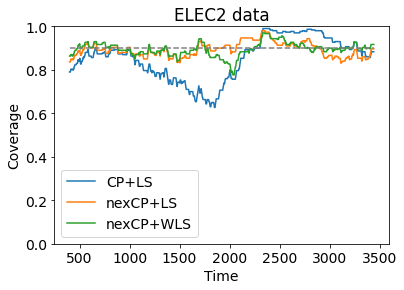

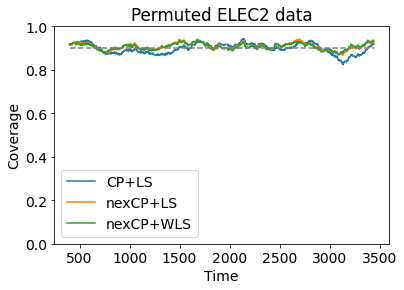

In [8]:
sm_cov_CP_LS = rolling_avg(cov_CP_LS,window)
sm_cov_nexCP_LS = rolling_avg(cov_nexCP_LS,window)
sm_cov_nexCP_WLS = rolling_avg(cov_nexCP_WLS,window)

sm_cov_CP_LS_perm = rolling_avg(cov_CP_LS_perm,window)
sm_cov_nexCP_LS_perm = rolling_avg(cov_nexCP_LS_perm,window)
sm_cov_nexCP_WLS_perm = rolling_avg(cov_nexCP_WLS_perm,window)

plt.rcParams.update({'font.size': 14})

plt.plot(np.arange(train_lag+window,N),sm_cov_CP_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_LS)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_WLS)
plt.hlines(1-alpha,xmin=train_lag+window,xmax=N,linestyles='--',colors='gray')
plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
plt.ylabel('Coverage')
plt.xlabel('Time')
plt.title('ELEC2 data')
plt.ylim([0,1])
plt.savefig('results/ELEC2_coverage.png',dpi=400,bbox_inches='tight')
plt.show()


plt.plot(np.arange(train_lag+window,N),sm_cov_CP_LS_perm)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_LS_perm)
plt.plot(np.arange(train_lag+window,N),sm_cov_nexCP_WLS_perm)
plt.hlines(1-alpha,xmin=train_lag+window,xmax=N,linestyles='--',colors='gray')
plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
plt.ylabel('Coverage')
plt.xlabel('Time')
plt.title('Permuted ELEC2 data')
plt.ylim([0,1])
plt.savefig('results/ELEC2_perm_coverage.png',dpi=400,bbox_inches='tight')
plt.show()

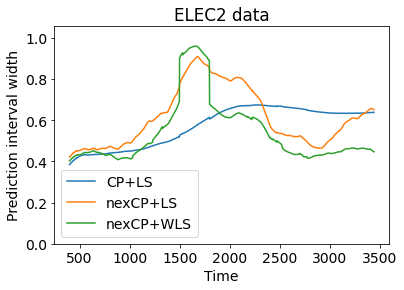

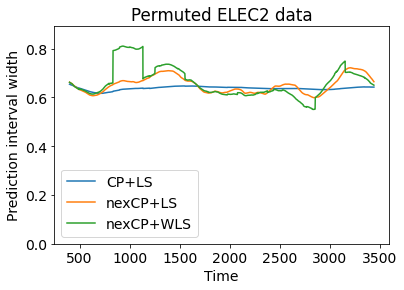

In [9]:
sm_PI_width_CP_LS = rolling_avg(PI_width_CP_LS,window)
sm_PI_width_nexCP_LS = rolling_avg(PI_width_nexCP_LS,window)
sm_PI_width_nexCP_WLS = rolling_avg(PI_width_nexCP_WLS,window)

sm_PI_width_CP_LS_perm = rolling_avg(PI_width_CP_LS_perm,window)
sm_PI_width_nexCP_LS_perm = rolling_avg(PI_width_nexCP_LS_perm,window)
sm_PI_width_nexCP_WLS_perm = rolling_avg(PI_width_nexCP_WLS_perm,window)

plt.rcParams.update({'font.size': 14})

plt.plot(np.arange(train_lag+window,N),sm_PI_width_CP_LS)
plt.plot(np.arange(train_lag+window,N),sm_PI_width_nexCP_LS)
plt.plot(np.arange(train_lag+window,N),sm_PI_width_nexCP_WLS)
ymax = np.max(np.r_[sm_PI_width_CP_LS,sm_PI_width_nexCP_LS,\
                    sm_PI_width_nexCP_WLS])*1.1
plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
plt.ylabel('Prediction interval width')
plt.xlabel('Time')
plt.title('ELEC2 data')
plt.ylim([0,ymax])
plt.savefig('results/ELEC2_PI_width.png',dpi=400,bbox_inches='tight')
plt.show()

plt.plot(np.arange(train_lag+window,N),sm_PI_width_CP_LS_perm)
plt.plot(np.arange(train_lag+window,N),sm_PI_width_nexCP_LS_perm)
plt.plot(np.arange(train_lag+window,N),sm_PI_width_nexCP_WLS_perm)
ymax = np.max(np.r_[sm_PI_width_CP_LS_perm,sm_PI_width_nexCP_LS_perm,\
                    sm_PI_width_nexCP_WLS_perm])*1.1
plt.legend(['CP+LS','nexCP+LS','nexCP+WLS'])
plt.ylabel('Prediction interval width')
plt.xlabel('Time')
plt.title('Permuted ELEC2 data')
plt.ylim([0,ymax])
plt.savefig('results/ELEC2_perm_PI_width.png',dpi=400,bbox_inches='tight')
plt.show()